# Bulk RNA-Seq: Cohort Selection and Data Retrieval

This notebook demonstrates how to use the **Genestack ODM API** to access and explore bulk RNA-seq data stored in an ODM instance. It explains how to configure the API connection, retrieve metadata and data for selected entities, and interpret the returned results in a reproducible, programmable way.
The notebook is organized into three main parts:
* **Prerequisites** – loads the required Python libraries and helper functions. This section can be minimized when running the notebook end-to-end if all dependencies are already installed.
* **ODM API Configuration** – an interactive setup for establishing a secure connection to your ODM instance using an API token.
* **Working with Data** – examples of typical ODM API endpoints for metadata and data retrieval (including multi-omics), with explanations of the API response structure and its relevance for downstream analysis.

## 1. Prerequisites

Before running the notebook, make sure your environment is ready. You will need Python 3.10+ and `pip`. Install all dependencies with:
```
pip install odm-sdk numpy pandas matplotlib seaborn scipy ipywidgets ipykernel requests
```


### 1.1 Imports

In [6]:
# standard library (come with Python)
import os
import re
import json
import time
import warnings
from getpass import getpass
from io import StringIO

# third-party (need installation)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from scipy.stats import spearmanr, pearsonr
import requests
import odm_api

# set default matplotlib style
plt.style.use('default')

# set warnings to ignore FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning)

### 1.2 Functions

This section defines utility functions used across the notebook to streamline interaction with the ODM API and to support visualization of retrieved data. Collecting them here keeps the workflow sections concise and focused on analysis rather than implementation details.

In [7]:
def set_api_credentials(odm_url, api_prefix='/api/v1'):
    """
    Set ODM API credentials interactively, using getpass or fallback to widget-based UI.

    Attempts to use `getpass` to prompt for an API token (works in terminal environments).
    If that fails (e.g., in JupyterLab or web-based notebooks), falls back to a widget-based input form.

    Parameters
    ----------
    odm_url : str
        The ODM server URL, e.g. 'https://q001-demo.trial.genestack.com/'
    api_prefix : str, optional
        The API endpoint prefix (default is '/api/v1').

    Sets global variables
    ------------
        odm_base_url : str
            The base ODM API URL with prefix.
        token : str
            The provided API authentication token.
    """
    # ensure API prefix is provided with the URL
    if not re.search(r'/api.+', odm_url):
        base_url = odm_url + api_prefix

    try:
        # enter token via getpass (works in terminal-based environments)
        global odm_base_url, token
        token = getpass("Auth Token: ")
        odm_base_url = base_url

    except (EOFError, OSError):
        # fallback to widget-based input (works in web environments)
        set_api_credentials_ui(base_url)


def set_api_credentials_ui(base_url):
    """
    Displays widgets for ODM API server and token selection.

    Args:
        base_url (str, optional): Default server URL for ODM with API prefix (e.g. /api/v1).
        If not provided, uses 'ODM_BASE_URL' env variable or default.
    """
    odm_base_url_widget = widgets.Text(
        value=base_url if base_url is not None else os.getenv('ODM_BASE_URL', ''),
        description='Base URL:',
        layout=widgets.Layout(width='600px')
    )
    token_widget = widgets.Password(
        value=os.getenv('ODM_API_TOKEN', ''),
        description='Auth Token:',
        layout=widgets.Layout(width='400px')
    )
    set_button = widgets.Button(description='Set Credentials', button_style='primary')
    status_html = widgets.HTML()

    def _set_credentials(_):
        global odm_base_url, token
        odm_base_url = odm_base_url_widget.value.strip()
        token = token_widget.value.strip()
        masked = ('***' if not token else (token[:4] + '…' + token[-4:] if len(token) >= 8 else '***'))
        status_html.value = f"<span style='color: green;'>Credentials set. Token: {masked}</span>"

    set_button.on_click(_set_credentials)
    display(widgets.VBox([odm_base_url_widget, token_widget, set_button, status_html]))


def plot_grouped_violin(
    combined_data,
    group_by='Disease',
    preferred=None,
    log1p=True,
    figsize_scale=0.6,
    min_figsize=12,
    height=6
):
    """
    Plot grouped violin + strip plot, optionally log1p of expression,
    grouped by an inferred or specified metadata column.

    Parameters:
        combined_data (pd.DataFrame): DataFrame with expression data and sample metadata.
        group_by (str): Initial column to try as grouping variable (default: 'Disease').
        preferred (list): Optional list of preferred columns to scan as grouping variables.
        log1p (bool): Whether to plot log1p(expression). Default: True.
        figsize_scale (float): Scale for figure width by number of genes.
        min_figsize (int): Minimum figure width.
        height (float): Figure height.
    """

    sns.set(style="whitegrid", context="notebook")

    plot_df = combined_data.copy()

    # helper to normalize complex values (lists/dicts) to strings for grouping
    def _norm_group(v):
        if isinstance(v, (list, tuple, set)):
            return ', '.join(map(str, v))
        if isinstance(v, dict):
            return json.dumps(v, sort_keys=True)
        return v

    # determine/normalize a usable grouping column
    if preferred is None:
        preferred = ['Disease', 'Tissue', 'Cell Type', 'Project', 'Batch', 'Sex', 'Age']
    chosen = None
    if group_by in plot_df.columns:
        s = plot_df[group_by]
        if np.issubdtype(s.dtype, np.number):
            if s.nunique(dropna=True) >= 2:
                chosen = group_by
        else:
            s2 = s.map(_norm_group)
            if 2 <= s2.nunique(dropna=True) <= 10:
                plot_df[group_by] = s2
                chosen = group_by
    # fallback: scan preferred list
    if not chosen:
        for c in preferred:
            if c not in plot_df.columns:
                continue
            s = plot_df[c]
            if np.issubdtype(s.dtype, np.number):
                if s.nunique(dropna=True) >= 2:
                    bname = f'{c}_binned'
                    plot_df[bname] = pd.cut(
                        s,
                        bins=[-np.inf, 40, 50, 60, 70, 80, np.inf],
                        labels=['<=40', '40-50', '50-60', '60-70', '70-80', '80+']
                    )
                    chosen = bname
                    break
            else:
                s2 = s.map(_norm_group)
                if 2 <= s2.nunique(dropna=True) <= 10:
                    plot_df[c] = s2
                    chosen = c
                    break
    group_by = chosen

    # transform and ordering
    if log1p:
        y_col = 'log1p_value'
        plot_df[y_col] = np.log1p(plot_df['value'])
        ylabel = 'log1p(Expression)'
        title = 'Expression of gene selection (log1p)'
    else:
        y_col = 'value'
        ylabel = 'Expression'
        title = 'Expression of gene selection'

    order = (
        plot_df.groupby('gene')['value']
        .median()
        .sort_values(ascending=False)
        .index
    )

    plt.figure(figsize=(max(min_figsize, figsize_scale * len(order)), height))
    ax = sns.violinplot(
        data=plot_df, x='gene', y=y_col, order=order,
        hue=group_by, dodge=True, inner=None, cut=0, density_norm='width'
    )
    sns.stripplot(
        data=plot_df, x='gene', y=y_col, order=order,
        hue=group_by, dodge=True, size=3, jitter=0.25, alpha=0.6,
        linewidth=0, edgecolor=None
    )
    ax.set(xlabel='Gene', ylabel=ylabel, title=title)
    plt.xticks(rotation=45, ha='right')
    # clean up duplicate legends from violin+strip
    if group_by:
        if ax.legend_:
            ax.legend_.remove()
        plt.legend(title=group_by, bbox_to_anchor=(1.02, 1), loc='upper left')
    else:
        if ax.legend_:
            ax.legend_.remove()
    plt.tight_layout()
    plt.show()


def plot_grouped_heatmap(
    combined_data,
    group_by="Disease",
    value_col='value',
    gene_col='gene',
    sample_col="genestack:accession",
    cmap='vlag',
    log1p=True
):
    """
    Plot enhanced grouped heatmap: genes as rows, samples as columns (optionally group columns/colors).
    Shows gene names on the left side of the heatmap.

    Parameters
    ----------
    combined_data : pd.DataFrame
        DataFrame with gene expression data. Must contain gene_col, sample_col, value_col, and group_by.
    group_by : str
        Column to use for column color grouping (e.g., 'Disease').
    value_col : str
        Column with expression values.
    gene_col : str
        Column with gene names.
    sample_col : str
        Column with sample accessions.
    cmap : str
        Colormap to use for the heatmap.
    log1p : bool
        If True, log1p transform the expression values before visualization.
    """

    plot_df = combined_data.copy()

    def _norm_group(v):
        if isinstance(v, (list, tuple, set)):
            return ', '.join(map(str, v))
        if isinstance(v, dict):
            return json.dumps(v, sort_keys=True)
        return v

    # pivot and normalize matrix: genes as rows, samples as columns
    mat = plot_df.pivot_table(index=gene_col, columns=sample_col, values=value_col, aggfunc='median')

    if log1p:
        mat_proc = np.log1p(mat)
    else:
        mat_proc = mat

    mat_z = (mat_proc - mat_proc.mean(axis=1).values[:, None]) / mat_proc.std(axis=1, ddof=0).values[:, None]
    rows = mat_proc.median(axis=1).sort_values(ascending=False).index
    mat_z = mat_z.loc[rows]

    col_colors = None
    legend_handles = None
    palette = None

    # column colors by group
    if group_by and group_by in plot_df.columns:
        plot_df[group_by] = plot_df[group_by].map(_norm_group)
        meta = (
            plot_df[[sample_col, group_by]]
            .drop_duplicates().set_index(sample_col)
            .reindex(mat_z.columns)
        )
        levels = meta[group_by].astype('category').cat.categories
        palette = dict(zip(levels, sns.color_palette('Set2', n_colors=len(levels))))
        col_colors = meta[group_by].map(palette)
        mat_z = mat_z.loc[:, meta.sort_values(group_by).index]  # sort columns (samples) by group
        # prepare legend handles
        legend_handles = [
            mpatches.Patch(color=palette[level], label=str(level)) for level in levels
        ]

    # create clustermap: genes as rows, samples as columns
    g = sns.clustermap(
        mat_z,
        cmap=cmap,
        center=0,
        row_cluster=False,
        col_cluster=False,
        col_colors=col_colors,
        cbar_kws={'label': 'Z-score (per gene)'},
        figsize=(max(8, 0.22 * len(mat_z.columns)), max(8, 0.4 * len(rows))),
        linewidths=0.1,
        xticklabels=True,
        yticklabels=True,
        dendrogram_ratio=(.08, .02),  # row dendrogram larger, as genes are now rows
        cbar_pos=(0.94, 0.7, 0.02, 0.18)
    )
    g.ax_heatmap.set_xlabel('Sample', fontsize=13, fontweight='bold')
    g.ax_heatmap.set_ylabel('Gene', fontsize=13, fontweight='bold')
    g.ax_heatmap.tick_params(axis='x', rotation=90, labelsize=10)
    g.ax_heatmap.tick_params(axis='y', labelsize=10, labelleft=True, labelright=False)  # only show tick labels on the left

    # add better title and annotation
    if log1p:
        title = f'Expression heatmap for gene selection\n(log1p, per-gene z-score)'
    else:
        title = f'Expression heatmap for gene selection\n(per-gene z-score)'
    if group_by and group_by in plot_df.columns:
        title += f'\nGrouped by: {group_by}'
    g.ax_heatmap.set_title(title, fontsize=15, fontweight='bold', pad=18)

    # move cbar for better visibility
    g.cax.set_position([.93, .18, .02, .55])

    # show group (disease) legend at the top right of the plot, but do not show the title
    if legend_handles is not None:
        # place legend at top right of the figure, outside plot area
        g.ax_heatmap.legend(
            handles=legend_handles,
            title=None,
            loc='upper right',
            bbox_to_anchor=(1.12, 1.01),  # (x, y) as fraction of axes; adjust as needed
            borderaxespad=0.0,
            fontsize='small',
            frameon=False,
            ncol=1
        )

    # show gene names on the left side only: hide any right-side y-tick labels
    g.ax_heatmap.yaxis.tick_left()
    g.ax_heatmap.yaxis.set_label_position("left")
    g.ax_heatmap.yaxis.set_ticks_position("left")
    g.ax_heatmap.tick_params(axis='y', which='both', labelleft=True, labelright=False)

    plt.show()


def plot_correlation_scatter(data, title, method='pearson', color_by=None, width=None, height=None):
    """
    Create a scatter plot with regression line and correlation statistics,
    with optional color annotation.

    Parameters
    ----------
    data : pd.DataFrame
        DataFrame with two numeric columns (e.g., 'transcript' and 'protein').
    title : str
        Title for the plot.
    method : str, optional
        Correlation method to use. Either 'pearson' or 'spearman' (default: 'pearson').
    color_by : str, optional
        Column name in `data` to color points by. May be numeric or categorical.
    width : float, optional
        Width of the figure in inches. If not provided, default figure size is used.
    height : float, optional
        Height of the figure in inches. If not provided, default figure size is used.

    Returns
    -------
    None
        Displays the plot.

    Examples
    --------
    >>> import pandas as pd
    >>> import numpy as np
    >>> df = pd.DataFrame({
    ...     'transcript': np.random.randn(100),
    ...     'protein': np.random.randn(100),
    ...     'disease': np.random.choice(['NASH', 'Healthy'], size=100)
    ... })
    >>> plot_correlation_scatter(df, 'Gene_A', 'spearman', color_by='disease')
    """
    # use first two numeric columns
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) < 2:
        raise ValueError("DataFrame must contain at least two numeric columns.")
    x_col = numeric_cols[0]
    y_col = numeric_cols[1]

    # extract data and remove NaN values (in x, y, and possibly color_by)
    cols_to_check = [x_col, y_col]
    if color_by is not None:
        cols_to_check.append(color_by)
    mask = ~data[cols_to_check].isna().any(axis=1)
    clean_data = data.loc[mask]

    x_clean = clean_data[x_col].values
    y_clean = clean_data[y_col].values

    if len(x_clean) < 3:
        raise ValueError("Not enough valid data points (need at least 3) for correlation calculation.")

    # calculate correlation
    if method.lower() == 'pearson':
        corr_coef, p_value = pearsonr(x_clean, y_clean)
    elif method.lower() == 'spearman':
        corr_coef, p_value = spearmanr(x_clean, y_clean)
    else:
        raise ValueError("method must be either 'pearson' or 'spearman'.")

    # handle color_by logic
    color_vals = None
    color_legend_info = None
    from matplotlib.lines import Line2D

    if color_by is not None and color_by in clean_data.columns:
        color_data = clean_data[color_by]
        if pd.api.types.is_numeric_dtype(color_data):
            # Numeric, use colormap
            cmap = plt.cm.viridis
            color_vals = color_data.values
            sc_kwargs = dict(c=color_vals, cmap=cmap)
            color_legend_info = 'numeric'
        else:
            # Categorical
            unique_cats = color_data.unique()
            n_categories = len(unique_cats)
            # Use tab10 or another colormap
            cmap = plt.get_cmap('tab10') if n_categories <= 10 else plt.get_cmap('tab20')
            color_map = {cat: cmap(i % cmap.N) for i, cat in enumerate(unique_cats)}
            color_vals = color_data.map(color_map)
            sc_kwargs = dict(c=color_vals)
            color_legend_info = (unique_cats, color_map)
    else:
        sc_kwargs = {}

    # create scatter plot with appropriate figure size and tight layout usage
    if width is not None and height is not None:
        plt.figure(figsize=(width, height))
        use_tight_layout = False
    else:
        plt.figure()
        use_tight_layout = True

    ax = plt.gca()
    scatter = plt.scatter(
        x_clean,
        y_clean,
        alpha=0.7,
        s=50,
        **sc_kwargs
    )

    # add regression line
    z = np.polyfit(x_clean, y_clean, 1)
    p = np.poly1d(z)
    x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
    plt.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, label='Regression line')

    # add correlation statistics in top left corner
    stats_text = f'r = {corr_coef:.3f}\np = {p_value:.2e}'
    plt.text(0.05, 0.95, stats_text, transform=ax.transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # set labels and title
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # add color legend/colorbar at right center if requested
    if color_by is not None and color_by in clean_data.columns:
        if color_legend_info == 'numeric':
            cbar = plt.colorbar(scatter, ax=ax, fraction=0.05, pad=0.12)
            cbar.set_label(color_by, fontsize=12)
            cbar.ax.yaxis.set_ticks_position('right')
            cbar.ax.yaxis.set_label_position('right')
        else:
            unique_cats, color_map = color_legend_info
            handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[cat],
                              markersize=8, label=str(cat))
                       for cat in unique_cats]
            # Place legend at right center, outside plot
            ax.legend(
                handles=handles,
                title=color_by,
                loc='center left',
                bbox_to_anchor=(1.03, 0.5),
                borderaxespad=0.0,
                fontsize='small',
                frameon=False
            )

    if use_tight_layout:
        plt.tight_layout()
    plt.show()


def map_protein_to_gene(protein_names, organism="Homo sapiens"):
    """
    Map protein names to human gene names using UniProt REST API.

    Parameters
    ----------
    protein_names : list
        List of protein names to map (e.g., ['c-Met', 'Rictor', 'Paxillin']).
    organism : str, optional
        Organism filter for UniProt search (default: "Homo sapiens").

    Returns
    -------
    dict
        Dictionary mapping protein names to gene names.
        If a protein name cannot be mapped, the value will be None.

    Examples
    --------
    >>> protein_names = ['c-Met', 'Rictor', 'Paxillin', 'p21']
    >>> gene_mapping = map_protein_to_gene(protein_names)
    >>> print(gene_mapping)
    {'c-Met': 'MET', 'Rictor': 'RICTOR', 'Paxillin': 'PXN', 'p21': 'CDKN1A'}
    """
    mapping = {}
    base_url = "https://rest.uniprot.org/uniprotkb/search"

    for protein_name in protein_names:
        # skip if already processed
        if protein_name in mapping:
            continue

        # clean protein name for search (remove common suffixes/prefixes)
        search_name = protein_name.strip()

        # build query: search by protein name and organism
        query = f'name:"{search_name}" AND organism:"{organism}"'
        query = f"protein_name:{search_name} AND organism_name:{organism} AND reviewed:true "
        params = {
            'query': query,
            'fields': 'gene_names',
            'format': 'json',
            'size': 1  # Only need first result
        }

        try:
            # make API request
            response = requests.get(base_url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()

            # extract gene name from response
            gene_name = None
            if data.get('results') and len(data['results']) > 0:
                result = data['results'][0]
                # try to get gene name from geneNames field
                if 'genes' in result and len(result['genes']) > 0:
                    gene_info = result['genes'][0]
                    # prefer geneName over synonyms
                    if 'geneName' in gene_info:
                        gene_name = gene_info['geneName'].get('value')
                    elif 'synonyms' in gene_info and len(gene_info['synonyms']) > 0:
                        # fallback to first synonym if geneName not available
                        gene_name = gene_info['synonyms'][0].get('value')

            mapping[protein_name] = gene_name

            # small delay to respect API rate limits
            time.sleep(0.01)

        except requests.exceptions.RequestException as e:
            # if API request fails, set to None
            mapping[protein_name] = None
            print(f"Warning: Could not map '{protein_name}': {str(e)}")
        except (KeyError, IndexError) as e:
            # if response structure is unexpected, set to None
            mapping[protein_name] = None
            print(f"Warning: Unexpected response format for '{protein_name}': {str(e)}")

    return mapping


def compute_correlation_with_pvalue(df1, df2, axis=1, method='pearson'):
    """
    Compute correlation coefficient and p-value between two dataframes or series.
    Both df1 and df2 must have identical indexes and columns for axis=None.
    For axis=0 or 1, computes correlation column-wise or row-wise.

    Args:
        df1, df2: pd.DataFrame or pd.Series
        axis: If 0, computes correlation over rows for each column.
              If 1, computes correlation over columns for each row.
        method: If 'pearson', computes Pearson correlation.
                If 'spearman', computes Spearman correlation.
                Default is 'pearson'.
    Returns:
        pd.Series or pd.DataFrame: results with {'r': ..., 'p_value': ...}
    """
    # determine which correlation function to use
    if method == 'pearson':
        corr_func = pearsonr
        r_name = 'pearson_r'
    elif method == 'spearman':
        corr_func = spearmanr
        r_name = 'spearman_r'
    else:
        raise ValueError("method must be either 'pearson' or 'spearman'.")

    if axis == 0:
        # match columns, compute over rows for each column
        if not all(df1.columns == df2.columns):
            raise ValueError("Columns of the two dataframes are not identical.")

        corrs = []
        for col in df1.columns:
            x = df1[col]
            y = df2[col]
            mask = ~(pd.isna(x) | pd.isna(y))
            if mask.sum() < 3:
                corrs.append({r_name: np.nan, 'p_value': np.nan})
            else:
                corr, pval = corr_func(x[mask], y[mask])
                corrs.append({r_name: corr, 'p_value': pval})
        return pd.DataFrame(corrs, index=df1.columns)

    elif axis == 1:
        # match index, compute over columns for each row
        if not df1.index.equals(df2.index):
            raise ValueError("Indexes of the two dataframes are not identical.")

        corrs = []
        for row in df1.index:
            x = df1.loc[row, :]
            y = df2.loc[row, :]
            mask = ~(pd.isna(x) | pd.isna(y))
            if mask.sum() < 3:
                corrs.append({r_name: np.nan, 'p_value': np.nan})
            else:
                corr, pval = corr_func(x[mask], y[mask])
                corrs.append({r_name: corr, 'p_value': pval})
        return pd.DataFrame(corrs, index=df1.index)

    else:
        raise ValueError("axis must be None, 0, or 1")

## 2. ODM API configuration

**Configuring Access to Your ODM Instance**

Before querying data, establish a connection to your ODM deployment and authenticate using an API token.  
The ODM API uses token-based authentication, allowing secure programmatic access while preserving user-level permissions.

In this section:
* **Specify the ODM instance URL** – defines the environment you are connecting to.  
* **Provide the API token** – identifies and authorizes your user session.  
* **Initialize the ODM API client** – creates the communication layer for all subsequent requests.


In [8]:
# input ODM server address
server = 'https://q001-demo.trial.genestack.com/'

# input API token
set_api_credentials(server)

Auth Token:  ········


In [9]:
# credentials sanity check
if len(token)==0:
    print("Failed to paste API token from clipboard! Set the token manually (e.g. via `token = 'your_token'`).")
else:
    print("Token successfully set!")

Token successfully set!


In [10]:
# initialize API client
configuration = odm_api.Configuration(
    host=server,
    api_key={'Genestack-API-Token': token}
)
api_client = odm_api.ApiClient(configuration)

# read odm-api documentation from
print(f"{server}/user-docs/tools/odm-api/python/generated/")

https://q001-demo.trial.genestack.com//user-docs/tools/odm-api/python/generated/


## 3. Working with Data

### 3.1 Exploring Sample Endpoints

In ODM, each entity—such as samples, datasets, or assays—can be accessed through dedicated API endpoints.
The `Sample` class provides programmatic access to sample-level metadata, enabling you to search, retrieve, and inspect samples based on their attributes and values.

In this step, the `Sample` interface is initialized, and its available methods are listed.

In [11]:
# initialize API class
sample_api = odm_api.SampleSPoTAsUserApi(api_client)

# list all available sample_api endpoints
for item in [item for item in dir(sample_api) if item.endswith("_as_user")]:
    print(item)

get_sample_as_user
get_sample_by_version_as_user
get_sample_versions_as_user
search_samples_as_user


### 3.2 Searching for Samples

This section demonstrates how to retrieve sample metadata using the `search_samples_as_user` endpoint.
The endpoint supports two complementary input parameters:

* `query` — performs a full-text search across all metadata fields.

* `filter` — applies logical conditions using metadata key–value pairs.

Both can be combined in a single request for flexible data retrieval.
The response includes:

* `meta` – summary information about the search results.

* `data` – a list of matching samples with their metadata attributes.

First, we will show how to retrieve a big number of samples for demonstration of `page_offset` parameter use when the number of samples is exceeding the `page_limit`.

In [12]:
# define search parameters
sample_filter = 'Organism="Homo sapiens"'

# batch 1:retrieve first 2000 items from all the human samples query
samples_batch1 = sample_api.search_samples_as_user(
    filter=sample_filter,
    page_limit=2000,
    page_offset=0
)

# batch 2: retrieve thje rest of items from all the human samples query
# by setting 'page_offset' parameter equal to 'count' retrieved in 1st batch
samples_batch2 = sample_api.search_samples_as_user(
    filter=sample_filter,
    page_limit=2000,
    page_offset=1990
)

# show summary items from API responses
print(json.dumps(samples_batch1.meta.to_dict(), indent=2))
print(json.dumps(samples_batch2.meta.to_dict(), indent=2))

{
  "pagination": {
    "count": 1990,
    "total": 2536,
    "offset": 0,
    "limit": 2000
  }
}
{
  "pagination": {
    "count": 546,
    "total": 2536,
    "offset": 1990,
    "limit": 2000
  }
}


Next, we will use both sample query and filter parameters to retrieve and explore a specific list of samples.

In [13]:
# define search parameters
sample_query = 'steatohepatitis'
sample_filter = 'Organism="Homo sapiens" AND Tissue="liver"'

# search samples with both query and filter parameters
samples = sample_api.search_samples_as_user(
    filter=sample_filter,
    query=sample_query
)

# show first items from API response
print(json.dumps(samples.meta.to_dict(), indent=2))
print(json.dumps(samples.data[0], indent=2))

{
  "pagination": {
    "count": 48,
    "total": 48,
    "offset": 0,
    "limit": 2000
  }
}
{
  "genestack:accession": "GSF024809",
  "Sample Source ID": "SAMN10979936",
  "Sample Name": "NASH_1",
  "Sample of origin": null,
  "Donor ID": null,
  "Organism": "Homo sapiens",
  "Disease": "metabolic dysfunction-associated steatohepatitis",
  "Sex": "male",
  "Age": 38,
  "Age Unit": null,
  "Body Mass Index (BMI)": null,
  "Body Mass Index (BMI) Unit": null,
  "Organ": null,
  "Tissue": "liver",
  "Cell Type": null,
  "Cell Line": null,
  "Genotype": null,
  "Biomarkers": null,
  "Treatment / Compound": null,
  "Treatment / Dose": null,
  "Treatment / Dose Unit": null,
  "Treatment / Time Point": null,
  "Treatment / Time Unit": null,
  "Comment": null,
  "Data Files / Raw": "https://www.ncbi.nlm.nih.gov/sra?term=SRX5401574",
  "Data Files / Processed": null,
  "Source URL": null,
  "groupId": "GSF024793"
}


### 3.3 Exploring Sample Metadata Summary

This section summarizes the metadata attributes available in the retrieved sample set.
The sample records returned by the API are converted into a DataFrame, and basic statistics are calculated to inspect attribute completeness and diversity.

For each metadata field, the table shows:

* `unique` – number of distinct values across all samples.

* `total` – total number of samples included.

* `top_values` – the most frequent attribute values observed.

In [14]:
# convert samples.data list of dicts to a DataFrame
samples_df = pd.DataFrame(samples.data).dropna(axis=1, how='all')

# compute summary statistics for most common attribute values
samples_summary = pd.DataFrame({
    'unique': samples_df.nunique(),
    'total': samples_df.shape[0],
    'top_values': samples_df.apply(
        lambda col: " / ".join(col.value_counts(dropna=False).index.astype(str))
    )
})

# show summary statistics
samples_summary.sort_values('unique')

,unique,total,top_values
Organism,1,48,Homo sapiens
Disease,1,48,metabolic dysfunction-associated steatohepatitis
Age,1,48,38
Tissue,1,48,liver
Sex,2,48,male / female
groupId,3,48,GSF024793 / GSF025135 / GSF025201
Sample Source ID,16,48,SAMN10979936 / SAMN10979935 / SAMN10979934 / S...
Sample Name,16,48,NASH_1 / NASH_2 / NASH_3 / NASH_4 / NASH_5 / N...
Data Files / Raw,16,48,https://www.ncbi.nlm.nih.gov/sra?term=SRX54015...
genestack:accession,48,48,GSF024809 / GSF024810 / GSF025161 / GSF025162 ...


### 3.4 Exploring Integration Endpoints

Unlike the previous sample endpoints that search for samples using their own attributes, integration endpoints allow you to find entities based on the attributes of related entities.
In this example, studies can be retrieved by filtering on the attributes of samples that belong to them.

The `StudyIntegrationApi` class provides methods for querying studies through their relationships with other entities such as samples, libraries, preparations, or files.

In [15]:
# initialize API class
study_integration_api = odm_api.StudyIntegrationAsUserApi(api_client)

# list all available study_api endpoints
for item in [item for item in dir(study_integration_api) if item.endswith("_as_user")]:
    print(item)

get_studies_by_files_as_user
get_studies_by_libraries_as_user
get_studies_by_preparations_as_user
get_studies_by_samples_as_user
get_study_by_file_as_user
get_study_by_sample_as_user
search_studies_by_filter_as_user


### 3.5 Retrieving Studies by Associated Samples

Integration endpoints allow identifying higher-level entities based on connected metadata objects.
Here, the `get_studies_by_samples_as_user` integration endpoint is utilized to link and retrieve studies to samples, employing the identical sample filter as the preceding step. These integration endpoints are designed to identify higher-level entities by leveraging their connected metadata objects.

In [16]:
# define search parameters
sample_query = 'steatohepatitis'
sample_filter = 'Organism="Homo sapiens" AND Tissue="liver"'

# search studies by sample groupId
studies = study_integration_api.get_studies_by_samples_as_user(
    filter=sample_filter,
    query=sample_query
)

# show associated studies metadata
studies_df = pd.DataFrame(studies.data).sort_values('genestack:accession')
studies_df = studies_df.drop_duplicates(subset='Study Source ID', keep='first')
studies_df = studies_df[~studies_df['Study Title'].str.contains('Test study')]
studies_df

,genestack:accession,Study Source,Study Source ID,Study Title,Study Description,Study Type,Study Design,Therapeutic Area,Target Disease,Information Classification,Personal Identifiable Information (PII),Data Steward,Data Steward Email,Status,Comment,Source URL
1,GSF024792,GEO,GSE126848,Demo - Hepatic transcriptome signatures in pat...,Non-alcoholic fatty liver disease (NAFLD) repr...,Profiling,"Liver biopsies from healthy, obese, NAFLD and ...",Liver Diseases,[metabolic dysfunction-associated steatohepati...,Public,None,None,None,Public on Feb 22 2019,None,https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi...


### 3.6 Exploring Omics Query Endpoints
Omics query endpoints provide access to quantitative datasets such as gene expression, variant, or flow cytometry data, along with their associated metadata.
These endpoints extend integration capabilities, enabling direct retrieval and filtering of omics measurements linked to specific samples or studies.

In this step, the `OmicsQueries` interface is initialized, and its available methods are listed to illustrate the range of omics data types accessible through the ODM API.

In [17]:
# initialize API class
omics_api = odm_api.OmicsQueriesAsUserApi(api_client)

# list all available omics_api endpoints
for item in [item for item in dir(omics_api) if item.endswith("_as_user")]:
    print(item)

omics_search_expression_data_as_user
omics_search_expression_groups_as_user
omics_search_flow_cytometry_data_as_user
omics_search_flow_cytometry_groups_as_user
omics_search_samples_as_user
omics_search_streamed_expression_data_as_user
omics_search_streamed_variant_data_as_user
omics_search_variant_data_as_user
omics_search_variant_groups_as_user


### 3.7 Searching Samples via Omics Query Endpoints

The `omics_search_samples_as_user` endpoint enables sample metadata search within the omics query interface.
It functions similarly to the standard sample search but supports additional integration — combining study-level filters with sample attributes and linking downstream omics data types.

The API response includes:

* `log` – textual summary of matched studies and samples.

* `data` – a list of metadata records for the retrieved samples.

This combined search allows coordinated retrieval of samples and their related omics datasets across studies.

In [18]:
# define search parameters
study_ids = studies_df["genestack:accession"].tolist()
study_filter = ' OR '.join([f'"genestack:accession"="{id}"' for id in study_ids])
sample_query = '"steatohepatitis" OR "healthy"'
sample_filter = 'Organism="Homo sapiens" AND Tissue="liver"'

# search samples with both study and sample query/filter parameters
omics_samples = omics_api.omics_search_samples_as_user(
    study_filter=study_filter,
    sample_query=sample_query,
    sample_filter=sample_filter,
    returned_metadata_fields='original_data_included'
)

# show first items from API response
print(json.dumps(omics_samples.log, indent=2))
print(json.dumps(omics_samples.data[0], indent=2))

[
  "Found 1 studies matched the study query (total number of found studies is 1 now)",
  "Found 30 samples matched the samples/study query (total number of found samples is 30 now)"
]
{
  "metadata": {
    "genestack:accession": "GSF024809",
    "Sample Source ID": "SAMN10979936",
    "Sample Name": "NASH_1",
    "Sample of origin": null,
    "Donor ID": null,
    "Organism": "Homo sapiens",
    "Disease": "metabolic dysfunction-associated steatohepatitis",
    "Sex": "male",
    "Age": 38,
    "Age Unit": null,
    "Body Mass Index (BMI)": null,
    "Body Mass Index (BMI) Unit": null,
    "Organ": null,
    "Tissue": "liver",
    "Cell Type": null,
    "Cell Line": null,
    "Genotype": null,
    "Biomarkers": null,
    "Treatment / Compound": null,
    "Treatment / Dose": null,
    "Treatment / Dose Unit": null,
    "Treatment / Time Point": null,
    "Treatment / Time Unit": null,
    "Comment": null,
    "Data Files / Raw": "https://www.ncbi.nlm.nih.gov/sra?term=SRX5401574",
    "

### 3.8 Visualizing Sample Metadata Distributions

This section illustrates how metadata attributes can be summarized and explored visually.
By converting the retrieved sample metadata JSON into a structured DataFrame, we can examine the distribution of key attributes such as study group, disease state, and sex.

The bar plots show how samples are distributed across these categories, enabling quick inspection of cohort balance and potential biases.
Visualizing attribute frequencies at this stage helps verify that metadata relationships are consistent before performing downstream omics queries or expression analyses.

In [19]:
# convert omics_samples.data list of nested dicts to a DataFrame
omics_samples_df = pd.DataFrame([
    item['metadata'] for item in omics_samples.data
])
omics_samples_df.dropna(axis=1, how='all', inplace=True)

# use disease abbreviation for visualization purposes
omics_samples_df.loc[omics_samples_df['Disease'].eq(
    "metabolic dysfunction-associated steatohepatitis"
), 'Disease'] = 'NASH'

# compute summary statistics for most common attribute values
omics_samples_summary = pd.DataFrame({
    'unique': omics_samples_df.nunique(),
    'total': omics_samples_df.shape[0],
    'top_values': omics_samples_df.apply(
        lambda col: " / ".join(col.value_counts(dropna=False).index.astype(str))
    )
})

# show summary statistics
omics_samples_summary.sort_values('unique')

,unique,total,top_values
Organism,1,30,Homo sapiens
Tissue,1,30,liver
groupId,1,30,GSF024793
Disease,2,30,NASH / Healthy
Sex,2,30,male / female
Age,2,30,38 / 39
Group,2,30,Test / Control
BMI,2,30,33.9 / 23.1
Steatosis Score,4,30,3 / 0 / 2 / 1
genestack:accession,30,30,GSF024809 / GSF024810 / GSF024835 / GSF024834 ...


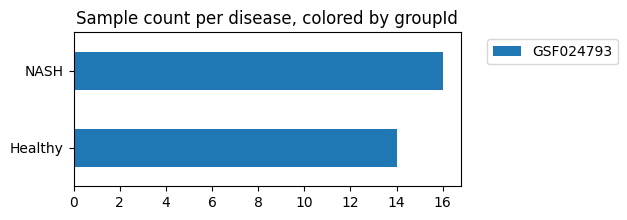

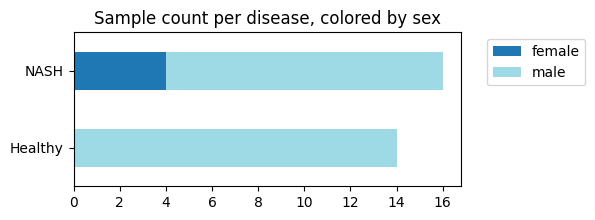

In [18]:
# plot frequencies for disease and groupId attributes
group_counts = pd.crosstab(omics_samples_df['Disease'], omics_samples_df['groupId'])
x = group_counts.plot(kind='barh', stacked=True, colormap='tab20', figsize=(5, 2))
x.set_ylabel('')
x.set_title("Sample count per disease, colored by groupId")
x.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# plot frequencies for disease and sex attributes
group_counts = pd.crosstab(omics_samples_df['Disease'], omics_samples_df['Sex'])
x = group_counts.plot(kind='barh', stacked=True, colormap='tab20', figsize=(5, 2))
x.set_ylabel('')
x.set_title("Sample count per disease, colored by sex")
x.legend(bbox_to_anchor=(1.05, 1))
plt.show()

### 3.9 Retrieving Expression Measurements

The `omics_search_expression_data_as_user` endpoint returns quantitative omics measurements with rich context.
Here we query by feature (gene symbols) and restrict results by sample accessions.

The response is a list of items; each item includes:

* `itemOrigin` – provenance identifiers (e.g., run and group).

* `metadata` – acquisition/processing details (platform, genome build, assay, files).

* `feature` – the targeted feature (e.g., gene symbol).

* `value` – the numeric measurement for that feature (representation depends on the dataset).

* `relationships` – linked entities such as the sample accession.


In [20]:
# define search parameters
genes = "CD36, CPT1A, CYP7A1, NR1H4, HMGCR, LDLR, LRP1, PPARA, SCARB1, SQLE"
genes = re.sub(r'\s+', '', genes)
ex_query = f"feature={genes}"
sample_ids = omics_samples_df["genestack:accession"].tolist()
sample_filter = ' OR '.join([f'"genestack:accession"="{id}"' for id in sample_ids])

# search expression data
ex_data = omics_api.omics_search_expression_data_as_user(
    ex_query=ex_query,
    sample_filter=sample_filter
)

# show first data item from API response
print(json.dumps(ex_data.data[0], indent=2))

{
  "itemId": "45215-CD36",
  "itemOrigin": {
    "runSourceId": "SAMN10979936",
    "runId": "45215",
    "groupId": "GSF024853"
  },
  "metadata": {
    "Features (numeric)": null,
    "Data Processing Method": null,
    "Genome Version": "GRCh38",
    "Platform": null,
    "Normalization Method": null,
    "Assay Type": "Bulk RNA-seq",
    "Values (numeric)": null,
    "Data Class": "Bulk transcriptomics",
    "Source URL": "https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126848",
    "Pipeline ID": null,
    "Preparation Method": null,
    "Experiment Site": "Gubra Institute, H\u00f8rsholm, Denmark",
    "Features (string)": "gene",
    "Data Files / Processed": null,
    "Data Files / Raw": "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE126848&format=file&file=GSE126848%5FGene%5Fcounts%5Fraw%2Etxt%2Egz"
  },
  "feature": {
    "gene": "CD36"
  },
  "value": {
    "value": 0.0
  },
  "relationships": {
    "sample": "GSF024809"
  }
}


After retrieving expression data, the next step is to combine all response items into a unified DataFrame for inspection.
Here, the metadata, feature, value, and relationship fields are merged, producing a tabular view of all expression records.

The summary table shows:

* `unique` – number of distinct values per attribute.

* `total` – total number of expression records.

* `top_values` – most common entries for each attribute.

In [21]:
# convert ex_data.data list of nested dicts to a DataFrame
expression_df = pd.DataFrame([
    item['metadata'] | item['feature'] | item['value'] | item['relationships']
    for item in ex_data.data
])
expression_df.dropna(axis=1, how='all', inplace=True)

# compute summary statistics for most common attribute values
ex_summary = pd.DataFrame({
    'unique': expression_df.nunique(),
    'total': expression_df.shape[0],
    'top_values': expression_df.apply(
        lambda col: " / ".join(col.value_counts(dropna=False).index.astype(str))
    )
})

# show summary statistics
ex_summary.sort_values('unique')

,unique,total,top_values
Genome Version,1,300,GRCh38
Assay Type,1,300,Bulk RNA-seq
Data Class,1,300,Bulk transcriptomics
Source URL,1,300,https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi...
Experiment Site,1,300,"Gubra Institute, Hørsholm, Denmark"
Features (string),1,300,gene
Data Files / Raw,1,300,https://www.ncbi.nlm.nih.gov/geo/download/?acc...
gene,10,300,CD36 / CPT1A / CYP7A1 / HMGCR / LDLR / LRP1 / ...
sample,30,300,GSF024809 / GSF024810 / GSF024837 / GSF024836 ...
value,177,300,0.0 / 7.0595981 / 4.620063 / 3.33824 / 0.69692...


The expression data is coming from 2 sources with similar processing protocols and the reads mapped to the GRCh38 genome. This allows cross-study integration of the expression values for further analysis.

### 3.10 Visualizing Gene Expression Distributions

Here, expression data are merged with sample metadata to enable joint visualization and context-aware interpretation.

In [22]:
# merge samples and expression data
combined_data = pd.merge(
    omics_samples_df,
    expression_df,
    left_on="genestack:accession",
    right_on="sample"
)

Boxplot of data distribution. Each box in the plot represents the distribution of expression values for one gene across all retrieved samples.

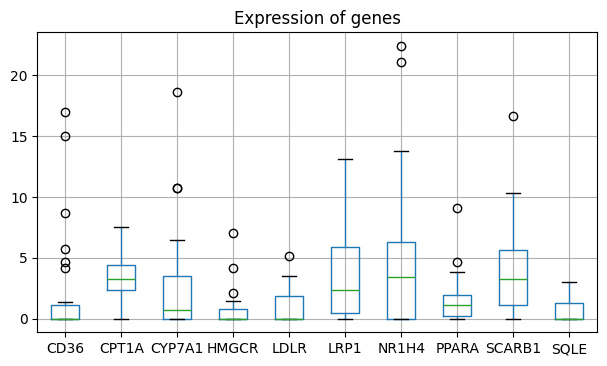

In [22]:
# plot expression values for each gene
x = combined_data.boxplot('value', 'gene', rot=0, figsize=(7,4))
x.set_title("Expression of genes")
x.set_xlabel('')
plt.suptitle('')
plt.show()

This heatmap presents normalized expression profiles for the selected genes, grouped by a chosen metadata attribute.
Here, expression values are transformed using a log1p scale and standardized as per-gene z-scores, allowing differences in relative expression levels to be compared across samples.

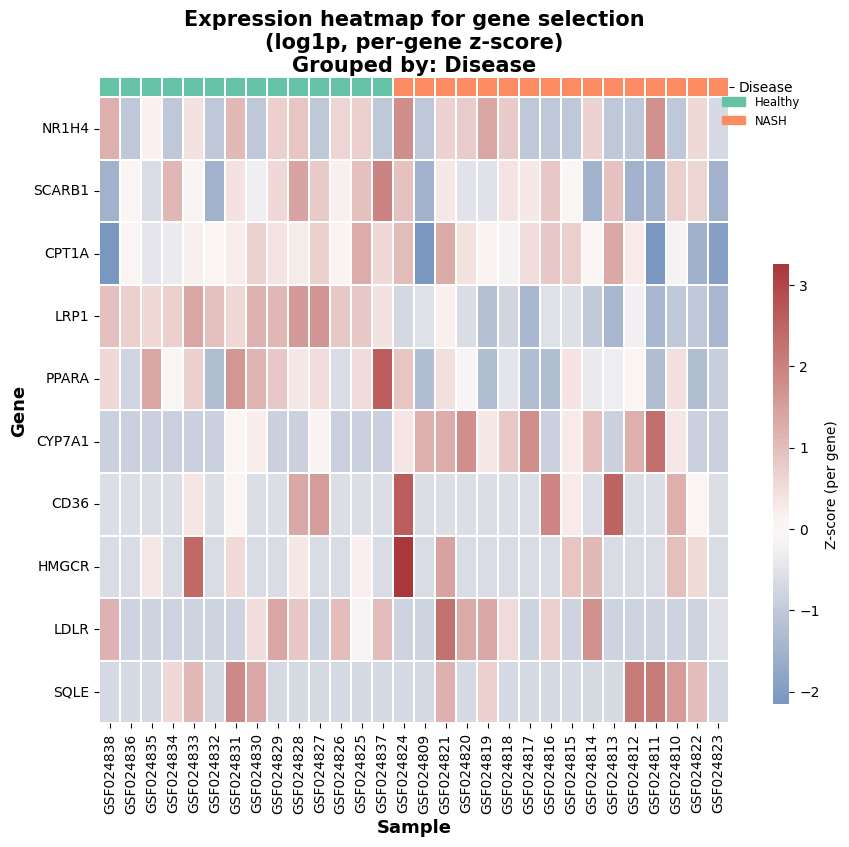

In [23]:
plot_grouped_heatmap(combined_data, group_by="Disease", log1p=True)

### 3.11 Comparing Gene Expression Across Groups

This plot visualizes the distribution of expression values for each gene, grouped by a categorical metadata attribute.

Here, log1p-transformed expression levels are shown as violin plots, providing a combined view of data density and variability across groups.

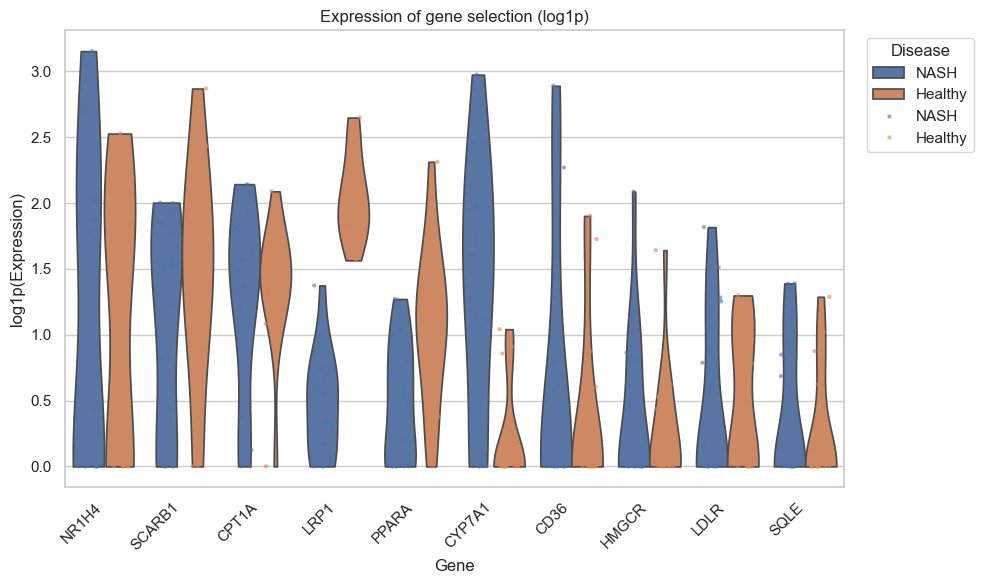

In [24]:
plot_grouped_violin(combined_data, group_by="Disease", log1p=True, min_figsize=10, height=6)

This plot shows expression distributions for each gene, grouped by a continuous metadata variable that has been binned into discrete intervals.

Here, expression values remain on the original scale, allowing direct interpretation of magnitude differences.

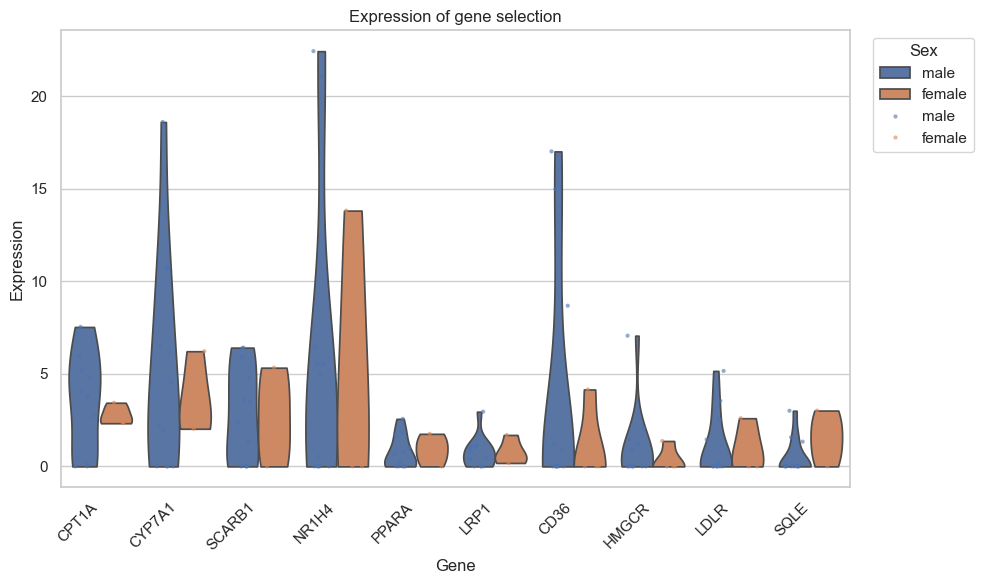

In [25]:
combined_data_filtered = combined_data.loc[combined_data["Disease"].eq("NASH")].copy()
plot_grouped_violin(combined_data_filtered, group_by="Age", log1p=False, min_figsize=10, height=6)

### 3.12 Filtering Samples by Quantitative and Qualitative Conditions

This example demonstrates how `omics_search_samples_as_user` can perform complex, multi-dimensional filtering across metadata and expression data.
Unlike earlier queries limited to categorical metadata (e.g., organism or tissue), this query also introduces quantitative and omics-based conditions within a single search.

Here, multiple query layers are combined:

* Categorical filters define biological context (organism, tissue, or study).

* Quantitative filters specify numeric constraints on metadata attributes (e.g., thresholds for age or concentration).

* Expression filters restrict samples by quantitative omics measurements, such as a minimum expression value for a gene of interest.

The API resolves these conditions in sequence, returning only samples that satisfy all specified filters.

In [27]:
# define search parameters
sample_query = "steatohepatitis"
sample_filter = 'Organism="Homo sapiens" AND Tissue="liver"'
ex_query = 'feature=NR1H4 value >= 4'

# search samples with both qualitative and quantitative query/filter parameters
omics_samples = omics_api.omics_search_samples_as_user(
    sample_query=sample_query,
    sample_filter=sample_filter,
    ex_query=ex_query
)

# show query
print(json.dumps(omics_samples.log, indent=2))

# extract sample ids
sample_ids = [
    item['metadata'].get('genestack:accession') for item in omics_samples.data
]
print("genestack:accession:", sample_ids)

[
  "Found 48 samples matched the samples/study query (total number of found samples is 48 now)",
  "Filtering using EXPRESSION signal data queries...",
  "Found 24 samples/libraries/preparations matching EXPRESSION queries",
  "Search took 79ms"
]
genestack:accession: ['GSF025153', 'GSF025156', 'GSF025160', 'GSF025161', 'GSF025162', 'GSF025163', 'GSF025164', 'GSF025166', 'GSF024811', 'GSF024814', 'GSF024818', 'GSF024819', 'GSF024820', 'GSF024821', 'GSF024822', 'GSF024824', 'GSF025222', 'GSF025226', 'GSF025227', 'GSF025219', 'GSF025228', 'GSF025229', 'GSF025230', 'GSF025232']


## 4. Working with Multi-Omics Data

### 4.1 Retrieving Samples with Multi-Omics Data

This section demonstrates how to query samples linked to multiple omics data types within the same biological context.
Using the `omics_search_samples_as_user` endpoint, searches can be refined not only by metadata attributes such as organism, disease, or tissue, but also by the type of omics data associated with each sample.

Here, two queries are executed using identical sample filters but different expression-data filters:

* Transcriptomics — samples linked to bulk RNA-seq data.

* Proteomics — samples linked to quantitative protein expression data.

The returned logs summarize how many samples matched the metadata conditions and how many contained corresponding expression datasets for each omics type.

In [23]:
# define search parameters
sample_filter = 'Organism="Homo sapiens" AND Disease="liver carcinoma" AND Tissue="liver"'
ex_filter_1 = '"Data Class"="Bulk transcriptomics"'
ex_filter_2 = '"Data Class"="Proteomics"'

# search transcriptomics samples
transcriptomics_samples = omics_api.omics_search_samples_as_user(
    sample_filter=sample_filter,
    ex_filter=ex_filter_1,
    returned_metadata_fields = 'original_data_included', # return all metadata attributes
    page_limit = 500
)

# search proteomics samples
proteomics_samples = omics_api.omics_search_samples_as_user(
    sample_filter=sample_filter,
    ex_filter=ex_filter_2,
    returned_metadata_fields = 'original_data_included', # return all metadata attributes
    page_limit = 500
)

# show first items from API response
print("Transcriptomics samples search log:")
print(json.dumps(transcriptomics_samples.log, indent=2))
print("")
print("Proteomics samples search log:")
print(json.dumps(proteomics_samples.log, indent=2))

Transcriptomics samples search log:
[
  "Found 200 samples matched the samples/study query (total number of found samples is 200 now)",
  "Filtering using EXPRESSION signal data queries...",
  "Found 193 samples/libraries/preparations matching EXPRESSION queries",
  "Search took 67ms",
  "Found 200 samples matched the samples/study query (total number of found samples is 400 now)",
  "Filtering using EXPRESSION signal data queries...",
  "Found 197 samples/libraries/preparations matching EXPRESSION queries",
  "Search took 46ms",
  "Found 39 samples matched the samples/study query (total number of found samples is 439 now)",
  "Filtering using EXPRESSION signal data queries...",
  "Found 39 samples/libraries/preparations matching EXPRESSION queries",
  "Search took 28ms"
]

Proteomics samples search log:
[
  "Found 200 samples matched the samples/study query (total number of found samples is 200 now)",
  "Filtering using EXPRESSION signal data queries...",
  "Found 107 samples/librarie

In [24]:
# find samples with both transcriptomics and proteomics data available
transcriptomics_sample_ids = [
    item['metadata'].get('genestack:accession')
    for item in transcriptomics_samples.data
]
proteomics_sample_ids = [
    item['metadata'].get('genestack:accession')
    for item in proteomics_samples.data
]

# find common sample ids
common_sample_ids = set(transcriptomics_sample_ids) & set(proteomics_sample_ids)
common_sample_ids = list(common_sample_ids)
print("Number of common sample ids:", len(common_sample_ids))

Number of common sample ids: 183


To link transcriptomics and proteomics data, we first identify the expression groups associated with the samples of interest.
Expression groups represent distinct experimental datasets describing quantitative measurements for a specific omics layer—such as gene expression or protein abundance.

Using the `omics_search_expression_groups_as_user` endpoint, we query for expression groups connected to the selected samples.
The response includes metadata describing each group’s experimental platform, data class, normalization method, and processing details.

In this example, the results reveal two complementary datasets: one corresponding to proteomics (protein expression data) and another to bulk transcriptomics (RNA-seq data).

In [25]:
# define search parameters
sample_query = ','.join(common_sample_ids)

# search expression groups
expression_groups = omics_api.omics_search_expression_groups_as_user(
    sample_query=sample_query
)

# show expression groups metadata
print(json.dumps(expression_groups.data, indent=2))

[
  {
    "itemId": "GSF024311",
    "metadata": {
      "Omics Platform ID": null,
      "Experimental Platform": null,
      "Features (numeric)": [
        "chromEnd",
        "chromStart"
      ],
      "Preparation QC": null,
      "Comment": null,
      "Experimental Platform Software Version": null,
      "Vendor": null,
      "Normalization Method": null,
      "Assay Type": null,
      "Values (numeric)": null,
      "Annotation": null,
      "genestack:activeInChain": null,
      "Data Class": "Bulk transcriptomics",
      "Pipeline ID": null,
      "Experimental Platform ID": null,
      "Processing QC Method": null,
      "genestack:chain": null,
      "Pipeline Version": null,
      "Data Source": null,
      "genestack:versionInChain": null,
      "Features (string)": [
        "Ensembl_ID",
        "chrom",
        "gene",
        "strand"
      ],
      "Library Preparation Protocol": null,
      "Alignment & Quantification Method": null,
      "Vendor Dataset ID": null

### 4.2 Retrieving Proteomics Expression Data in Tabular Format

Expression data can be retrieved using both `omics_search_expression_data_as_user` and `omics_search_streamed_expression_data_as_user` endpoints. The first one retrieves a `list of nested dictionaries` with the number of items listed equal to product of the number of runs and the number of features. Hence, it is useful for retrieval of expression metadata along with expression values for a limited number of features. Alternatively, data from one expression group can be retrieved as expression matrix in the `CSV streamed format`, which increases efficiency and reduces memory consumption. 

In the present example, we will get protein abundance for all the features within the given expression group.

In [26]:
# extract group ids for proteomics and transcriptomics data
proteomics_group_id = next(
    item['itemId']
    for item in expression_groups.data
    if item.get('metadata', {}).get('Data Class') == 'Proteomics'
)
transcriptomics_group_id = next(
    item['itemId']
    for item in expression_groups.data
    if item.get('metadata', {}).get('Data Class') == 'Bulk transcriptomics'
)

In [27]:
# pull proteomics expression data in tabular format for a given group
proteomics_data = omics_api.omics_search_streamed_expression_data_as_user(
    group_accession=proteomics_group_id
)

# transform proteomics_data streamed data to a DataFrame
proteomics_df = pd.read_csv(StringIO(proteomics_data))

# show first 5 rows and 5 columns
proteomics_df.iloc[:5,:5]

,peptide_target,TCGA-BC-4072-01B,TCGA-BC-A10Q-01A,TCGA-BC-A10R-01A,TCGA-BC-A10S-01A
0,SGK3,-0.5881,-0.3974,-0.3395,0.8321
1,MSI2,-0.4511,-0.6010,-0.4613,-0.6418
2,AMPKALPHA,-0.6388,-0.1572,-0.9657,-0.2893
3,BRD4,-1.1695,-1.6204,-1.1095,-1.2620
4,STING,-1.7425,-1.7846,-0.7696,-0.3772


### 4.3 Mapping Protein Identifiers to Gene Names

To integrate proteomics and transcriptomics datasets, protein identifiers must be aligned with their corresponding gene symbols.
This step extracts protein names from the proteomics expression data, cleans them by removing modification tags and formatting artifacts, and then maps them to gene names using a reference dictionary.

In [28]:
proteomics_df = proteomics_df.rename(columns={
    'peptide_target': 'Protein Group'
})

In [29]:
# remove PTMs from the 'Protein Group' column
proteomics_df = proteomics_df.loc[
    ~proteomics_df['Protein Group'].str.contains(r'\_p[A-Z]\d+.*', regex=True)
]

# remove "-X-Y" patterns from the protein names
proteomics_df['Protein Group'] = proteomics_df['Protein Group'].str.replace(r'\-[A-Z]\-[A-Z]$', '', regex=True)

# map protein names to gene names
protein_names_list = list(proteomics_df['Protein Group'].values)
gene_mapping = map_protein_to_gene(protein_names_list)

# show summary
mapped_genes = [g for g in gene_mapping.values() if g is not None]
mapped_genes = [x for x in mapped_genes if x.isalnum()]
mapped_count = len(mapped_genes)
total_count = len(gene_mapping)
print(f"\nSummary: {mapped_count}/{total_count} proteins successfully mapped to gene names.")

# print first 10 key-value pairs
print("")
print("First 5 protein-to-gene mapping pairs:")
for protein, gene in list(gene_mapping.items())[:5]:
    status = gene if gene else "Not found"
    print(f"{protein:20s} -> {status}")


Summary: 195/367 proteins successfully mapped to gene names.

First 5 protein-to-gene mapping pairs:
SGK3                 -> SGK3
MSI2                 -> Not found
AMPKALPHA            -> Not found
BRD4                 -> BICRA
STING                -> STEEP1


### 4.4 Retrieving Transcriptomics Expression Data for Mapped Genes

With the protein-to-gene mapping established, we can now retrieve transcriptomics expression values for the corresponding genes.
Using the `omics_search_streamed_expression_data_as_user` endpoint, expression measurements are pulled directly in tabular format for a specified expression group.

In [31]:
# define search parameters
chunk_size = 100
transcriptomics_df = pd.DataFrame()
for i in range(0, len(mapped_genes), chunk_size):
    chunk = mapped_genes[i:i+chunk_size]
    genes = ','.join([id for id in chunk])
    ex_query = f"feature.gene={genes}"
    transcriptomics_data = omics_api.omics_search_streamed_expression_data_as_user(
        group_accession=transcriptomics_group_id,
        ex_query=ex_query
    )
    chunk_df = pd.read_csv(StringIO(transcriptomics_data))
    transcriptomics_df = pd.concat([transcriptomics_df, chunk_df])
    
# show first 5 rows and 10 columns
transcriptomics_df.iloc[:5,:10]

,Ensembl_ID,chrom,chromEnd,chromStart,gene,strand,TCGA-2V-A95S-01A,TCGA-2Y-A9GS-01A,TCGA-2Y-A9GT-01A,TCGA-2Y-A9GU-01A
0,ENSG00000134258.17,chr1,117210960,117143587,VTCN1,-,4.3923,6.9425,2.3219,1.5850
1,ENSG00000141736.14,chr17,39730426,39687914,ERBB2,+,9.5680,12.0566,13.2512,9.3106
2,ENSG00000078237.7,chr12,4360028,4307763,TIGAR,+,6.9887,6.3399,6.4594,6.1293
3,ENSG00000163956.13,chr4,3532446,3503612,LRPAP1,-,12.2685,12.3902,11.8564,13.4690
4,ENSG00000189030.10,chr1,156299307,156298624,VHLL,-,0.0000,1.0000,1.0000,0.0000


### 4.5 Aligning Transcriptomics and Proteomics by Shared Identifiers

To enable direct, pairwise comparisons across omics layers, both datasets are aligned on a common sample identifier and a shared feature key.

In [46]:
# 4.5 Aligning Transcriptomics and Proteomics by Shared Identifiers

# Helper: ensure transcriptomics has a 'Gene Name' column
def ensure_gene_name_column(df):
    df = df.copy()

    cols = df.columns.tolist()

    # case 1: already there
    if "Gene Name" in cols:
        return df

    # case 2: column is called 'gene'
    if "gene" in cols:
        df = df.rename(columns={"gene": "Gene Name"})
        return df

    # case 3: gene names are in the index -> move them to a column
    df_reset = df.reset_index()
    # first column after reset_index holds the old index
    first_col = df_reset.columns[0]
    if first_col not in ["Gene Name", "gene"]:
        df_reset = df_reset.rename(columns={first_col: "Gene Name"})
    else:
        df_reset = df_reset.rename(columns={first_col: "Gene Name"})
    return df_reset

# Helper: ensure proteomics has a 'Protein Group' column (not hidden in index)
def ensure_protein_group_column(df):
    df = df.copy()
    if "Protein Group" in df.columns:
        return df
    # assume index holds protein IDs
    df_reset = df.reset_index()
    first_col = df_reset.columns[0]
    if first_col != "Protein Group":
        df_reset = df_reset.rename(columns={first_col: "Protein Group"})
    return df_reset

# 1) Prepare clean copies with explicit gene/protein columns
transcriptomics_clean = ensure_gene_name_column(transcriptomics_df)
proteomics_clean = ensure_protein_group_column(proteomics_df)

# 2) Common sample IDs (intersection of columns)
common_sample_source_ids = list(
    set(transcriptomics_clean.columns) & set(proteomics_clean.columns)
)
print("Number of common sample ids:", len(common_sample_source_ids))

# 3) Build mapping protein -> gene, but only keep genes present in transcriptomics data
valid_genes = set(transcriptomics_clean["Gene Name"])
common_gene_mapping = {
    protein: gene
    for protein, gene in gene_mapping.items()
    if gene in valid_genes
}
print("Proteins mapped to features in transcriptomics data:", len(common_gene_mapping))

common_gene_mapping_df = pd.DataFrame(
    list(common_gene_mapping.items()),
    columns=["Protein Group", "Gene Name"]
)

# 4) Build aligned expression matrices with Gene Name as index
proteomics_aligned = (
    common_gene_mapping_df
        .merge(proteomics_clean, on="Protein Group", how="inner")
        .set_index("Gene Name")[common_sample_source_ids]
)

transcriptomics_aligned = (
    common_gene_mapping_df
        .merge(transcriptomics_clean, on="Gene Name", how="inner")
        .set_index("Gene Name")[common_sample_source_ids]
)

print("Transcriptomics aligned shape:", transcriptomics_aligned.shape)
print("Proteomics aligned shape:    ", proteomics_aligned.shape)
print("Transcriptomics index example:", list(transcriptomics_aligned.index[:5]))
print("Proteomics index example:    ", list(proteomics_aligned.index[:5]))

Number of common sample ids: 181
Proteins mapped to features in transcriptomics data: 191
Transcriptomics aligned shape: (191, 181)
Proteomics aligned shape:     (191, 181)
Transcriptomics index example: ['SGK3', 'BICRA', 'LIME1', 'STK11IP', 'TMBIM6']
Proteomics index example:     ['SGK3', 'BICRA', 'LIME1', 'STK11IP', 'TMBIM6']


### 4.6 Exploring Samples Metadata Summary

In this step, we will explore samples metadata attributes, split them into categorical and continuous variables, and compute summary statistics for categorical variables.

In [34]:
# 4.6 Exploring Samples Metadata Summary

# 1) Build samples metadata DataFrame from transcriptomics_samples
samples_df = pd.DataFrame([item["metadata"] for item in transcriptomics_samples.data])

# 2) Filter to common samples and clean metadata
samples_df = (
    samples_df
        .loc[samples_df["genestack:accession"].isin(common_sample_ids)]
        .replace(".", np.nan)
        .dropna(axis=1, how="any")          # drop columns with any missing values
        .apply(pd.to_numeric, errors="ignore")  # convert numeric-looking cols
)

print(f"Samples in metadata after filtering: {samples_df.shape[0]}")
print(f"Metadata columns after cleaning: {samples_df.shape[1]}")

# 3) Detect list-like columns (lists/dicts/sets) that break nunique/value_counts
listlike_cols = [
    col for col in samples_df.columns
    if samples_df[col].apply(lambda x: isinstance(x, (list, dict, set))).any()
]

if listlike_cols:
    print("Dropping list-like metadata columns from summary:", listlike_cols)
else:
    print("No list-like metadata columns detected.")

# Drop list-like columns for the summary
samples_df_simple = samples_df.drop(columns=listlike_cols)

# 4) Compute summary statistics for remaining columns
samples_summary = pd.DataFrame({
    "unique": samples_df_simple.nunique(),
    "total": samples_df_simple.shape[0],
    "top_values": samples_df_simple.apply(
        lambda col: " / ".join(col.value_counts(dropna=False).index.astype(str))
    ),
    "col_type": samples_df_simple.dtypes,
})

# 5) Continuous (numeric) variables
is_float = samples_summary["col_type"].apply(
    lambda dt: np.issubdtype(dt, np.floating)
)
summary_numeric = samples_summary[is_float]

print("\nContinuous variables:")
for item in summary_numeric.index:
    print(f"  - {item}")

# 6) Categorical columns with 2–10 unique values
summary_categorical = samples_summary.loc[
    ~is_float & samples_summary["unique"].between(2, 10)
].sort_values("unique")

print("\nCategorical variables (2–10 unique values):")
print(summary_categorical)

Samples in metadata after filtering: 183
Metadata columns after cleaning: 65
Dropping list-like metadata columns from summary: ['primary_diagnosis.diagnoses', 'treatment_id.treatments.diagnoses', 'treatment_or_therapy.treatments.diagnoses', 'treatment_type.treatments.diagnoses', 'submitter_id.treatments.diagnoses', 'state.treatments.diagnoses', 'updated_datetime.treatments.diagnoses']

Continuous variables:
  - age_at_index.demographic
  - days_to_diagnosis.diagnoses
  - initial_weight.samples

Categorical variables (2–10 unique values):
                                       unique  total  \
Donor Sex                                   2    183   
prior_malignancy.diagnoses                  2    183   
prior_treatment.diagnoses                   2    183   
synchronous_malignancy.diagnoses            2    183   
oct_embedded.samples                        2    183   
preservation_method.samples                 2    183   
ethnicity.demographic                       3    183   
vital_st

In [42]:
# Ensure that gene names are the index for both matrices

if "Gene Name" in transcriptomics_df.columns:
    transcriptomics_df = transcriptomics_df.set_index("Gene Name")

if "Gene Name" in proteomics_df.columns:
    proteomics_df = proteomics_df.set_index("Gene Name")

print("Transcriptomics index example:", list(transcriptomics_df.index[:5]))
print("Proteomics index example:", list(proteomics_df.index[:5]))

Transcriptomics index example: ['VTCN1', 'ERBB2', 'TIGAR', 'LRPAP1', 'VHLL']
Proteomics index example: [0, 1, 2, 3, 4]


### 4.7 Computing Correlation between Transcriptomics and Proteomics Expression Values

Expression values from the same samples are aligned and used for computing the correlation between the transcript and protein expression.

In [47]:
# 4.7 Computing Correlation between Transcriptomics and Proteomics

# 0) Ensure numeric
transcriptomics_num = transcriptomics_aligned.apply(pd.to_numeric, errors="coerce")
proteomics_num = proteomics_aligned.apply(pd.to_numeric, errors="coerce")

# 1) Align by common samples (should already match, but be safe)
common_samples = sorted(
    set(transcriptomics_num.columns) & set(proteomics_num.columns)
)
print("Number of common samples used for correlation:", len(common_samples))

transcriptomics_num = transcriptomics_num[common_samples]
proteomics_num = proteomics_num[common_samples]

# 2) Align by common genes and aggregate duplicates
common_genes = sorted(
    set(transcriptomics_num.index) & set(proteomics_num.index)
)
print("Number of common genes before grouping:", len(common_genes))

transcriptomics_corr = (
    transcriptomics_num
    .loc[common_genes]
    .groupby(level=0)
    .mean(numeric_only=True)
)
proteomics_corr = (
    proteomics_num
    .loc[common_genes]
    .groupby(level=0)
    .mean(numeric_only=True)
)

print("Transcriptomics (after grouping) genes:", transcriptomics_corr.shape[0])
print("Proteomics (after grouping) genes:    ", proteomics_corr.shape[0])

# 3) Final intersection after grouping
final_genes = sorted(
    set(transcriptomics_corr.index) & set(proteomics_corr.index)
)
print("Number of common genes used for final correlation:", len(final_genes))

transcriptomics_corr = transcriptomics_corr.loc[final_genes]
proteomics_corr = proteomics_corr.loc[final_genes]

assert transcriptomics_corr.shape == proteomics_corr.shape

print("Final matrices for correlation:")
print("  Transcriptomics:", transcriptomics_corr.shape)
print("  Proteomics:     ", proteomics_corr.shape)

# 4) Compute correlation
correlation_results = compute_correlation_with_pvalue(
    transcriptomics_corr,
    proteomics_corr,
    axis=1,
    method="spearman"
)

correlation_results.head()

Number of common samples used for correlation: 181
Number of common genes before grouping: 191
Transcriptomics (after grouping) genes: 191
Proteomics (after grouping) genes:     191
Number of common genes used for final correlation: 191
Final matrices for correlation:
  Transcriptomics: (191, 181)
  Proteomics:      (191, 181)


/var/folders/nx/n98hjx694d532xqn23kk4zwm0000gn/T/ipykernel_38949/3126845868.py:604: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = corr_func(x[mask], y[mask])


,spearman_r,p_value
Gene Name,,
ACACA,0.563935,1.383799e-16
ACSS2,0.699375,6.634647e-28
ACTL6B,-0.139668,6.076112e-02
AGAP3,-0.127530,8.711016e-02
AKIP1,0.231035,1.753019e-03


## 4.8 Exploring Metadata-Driven Multi-Omics Patterns

In the previous steps, we aligned transcriptomics and proteomics data across a shared set of samples and computed RNA–protein correlations for matched genes.

In this section, we move beyond gene-level pairs and examine how **clinical metadata influences multi-omics expression patterns**.

### What we will do:
- Select the top transcript–protein correlated genes  
- Combine RNA and protein signals into a unified matrix  
- Z-score features for comparability  
- **Group samples by a metadata attribute** (e.g., diagnosis, donor sex, staging)  
- Visualize a heatmap that highlights multi-omics patterns across clinical groups  

This grouped heatmap provides an interpretable, publication-style representation of how multi-omics profiles vary across biological or clinical categories.


Top positively correlated gene: SYK
Top negatively correlated gene: BAK1
Colouring points by: age_at_index.demographic


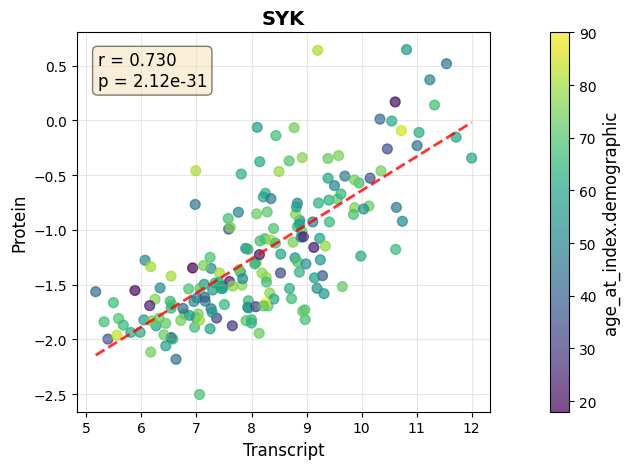

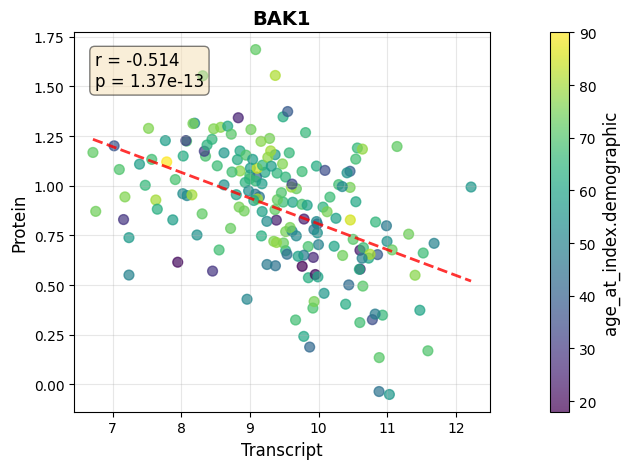

In [50]:
# 4.8 Visualising Correlation between Transcriptomics and Proteomics
# 1) Attach gene names to correlation results (one row per gene)
corr_with_gene = correlation_results.copy()
corr_with_gene["Gene"] = transcriptomics_corr.index.values  # gene symbols

# 2) Pick top positively and negatively correlated genes by Spearman r
top_pos_gene = (
    corr_with_gene.sort_values("spearman_r", ascending=False)["Gene"].iloc[0]
)
top_neg_gene = (
    corr_with_gene.sort_values("spearman_r", ascending=True)["Gene"].iloc[0]
)

print("Top positively correlated gene:", top_pos_gene)
print("Top negatively correlated gene:", top_neg_gene)

# 3) Decide which metadata column to use for colour
preferred_color_cols = [
    "DSS.time",
    "age_at_index.demographic",
    "days_to_diagnosis.diagnoses",
]
color_attr = next((c for c in preferred_color_cols if c in samples_df.columns), None)
print("Colouring points by:", color_attr if color_attr else "none (no suitable column found)")

# 4) Helper to build plotting DataFrame for a given gene
def prepare_plot_df(gene):
    # use the aligned matrices from 4.7
    df = pd.DataFrame({
        "Transcript": transcriptomics_corr.loc[gene, :],
        "Protein": proteomics_corr.loc[gene, :],
    })

    # decide join key between expression (columns) and samples_df
    join_key = "Sample Source ID" if "Sample Source ID" in samples_df.columns else "genestack:accession"
    df.index.name = join_key

    df = df.merge(
        samples_df,
        left_index=True,
        right_on=join_key,
        how="inner"
    )
    return df

# 5) Plot top positive correlation gene
plot_df_pos = prepare_plot_df(top_pos_gene)
plot_correlation_scatter(
    plot_df_pos,
    top_pos_gene,
    method="spearman",
    color_by=color_attr if color_attr else None,
)

# 6) Plot top negative correlation gene
plot_df_neg = prepare_plot_df(top_neg_gene)
plot_correlation_scatter(
    plot_df_neg,
    top_neg_gene,
    method="spearman",
    color_by=color_attr if color_attr else None,
)

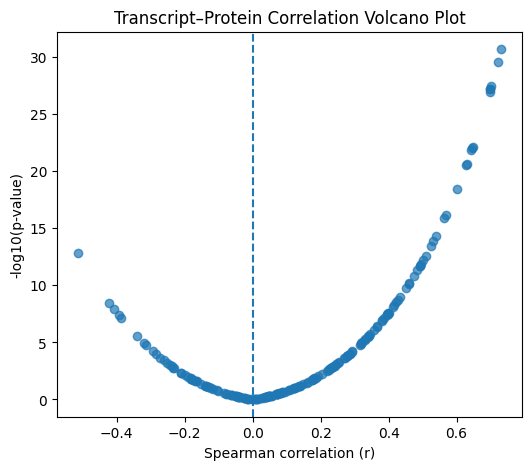

In [51]:
# 4.9 Volcano Plot of Transcript–Protein Correlations

volcano_df = correlation_results.copy()

# avoid log10(0)
eps = 1e-300
volcano_df["neg_log10_p"] = -np.log10(volcano_df["p_value"] + eps)
volcano_df["abs_r"] = volcano_df["spearman_r"].abs()

plt.figure(figsize=(6, 5))
plt.scatter(
    volcano_df["spearman_r"],
    volcano_df["neg_log10_p"],
    alpha=0.7
)
plt.axvline(0, linestyle="--")
plt.xlabel("Spearman correlation (r)")
plt.ylabel("-log10(p-value)")
plt.title("Transcript–Protein Correlation Volcano Plot")

plt.show()

Top 20 genes by |Spearman r|:
['SYK', 'HK2', 'IDO1', 'VASP', 'ACSS2', 'FGF2', 'CD276', 'ERBB2', 'SRC', 'ZAP70', 'PPIF', 'CDC25C', 'PAICS', 'ACACA', 'GAPDH', 'ENO1', 'SIRPA', 'BAK1', 'MSH6', 'HK1']


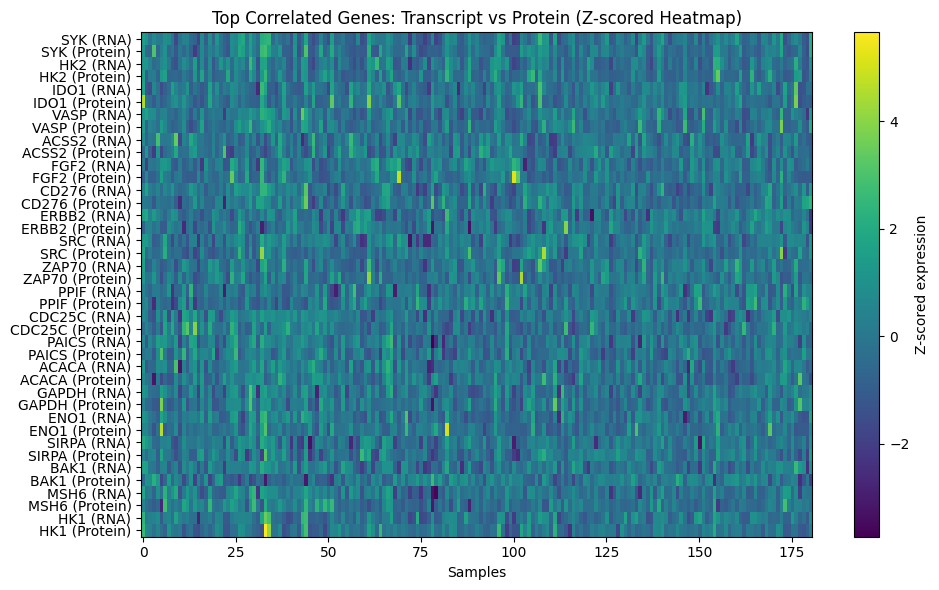

In [48]:
# 4.10 Heatmap of Top Correlated Genes (Transcript vs Protein)

corr_df = correlation_results.copy()
corr_df["Gene"] = transcriptomics_corr.index.values   # these are now gene symbols

top_n = 20
top_corr = corr_df.sort_values("spearman_r", key=lambda s: s.abs(), ascending=False)
top_genes = top_corr["Gene"].head(top_n).tolist()

print(f"Top {top_n} genes by |Spearman r|:")
print(top_genes)

rna_mat = transcriptomics_corr.loc[top_genes, :]
prot_mat = proteomics_corr.loc[top_genes, :]

def zscore_rows(df):
    mu = df.mean(axis=1)
    sigma = df.std(axis=1).replace(0, np.nan)
    return (df.sub(mu, axis=0)).div(sigma, axis=0)

rna_z = zscore_rows(rna_mat)
prot_z = zscore_rows(prot_mat)

combined = []
row_labels = []
for gene in top_genes:
    combined.append(rna_z.loc[gene].values)
    row_labels.append(f"{gene} (RNA)")
    combined.append(prot_z.loc[gene].values)
    row_labels.append(f"{gene} (Protein)")

combined = np.array(combined)

plt.figure(figsize=(10, 6))
im = plt.imshow(combined, aspect="auto")
plt.colorbar(im, label="Z-scored expression")
plt.yticks(range(len(row_labels)), row_labels)
plt.xlabel("Samples")
plt.title("Top Correlated Genes: Transcript vs Protein (Z-scored Heatmap)")
plt.tight_layout()
plt.show()

## Clustered heatmap with sample grouping by metadata
- Shows natural clusters among samples

- Lets you visually correlate omics patterns with clinical or biological features

In [64]:
import ipywidgets as widgets

available_meta = [
    "primary_diagnosis.diagnoses",
    "Donor Sex",
    "ajcc_pathologic_t.diagnoses",
]

meta_dropdown = widgets.Dropdown(
    options=[m for m in available_meta if m in samples_df.columns],
    description="Group by:",
    value="primary_diagnosis.diagnoses",
    style={'description_width': 'initial'}
)

display(meta_dropdown)

Dropdown(description='Group by:', options=('primary_diagnosis.diagnoses', 'Donor Sex', 'ajcc_pathologic_t.diag…

Top 20 genes by |Spearman r|:
['SYK', 'HK2', 'IDO1', 'VASP', 'ACSS2', 'FGF2', 'CD276', 'ERBB2', 'SRC', 'ZAP70', 'PPIF', 'CDC25C', 'PAICS', 'ACACA', 'GAPDH', 'ENO1', 'SIRPA', 'BAK1', 'MSH6', 'HK1']
Grouping samples by: Donor Sex
Grouping samples by: Donor Sex


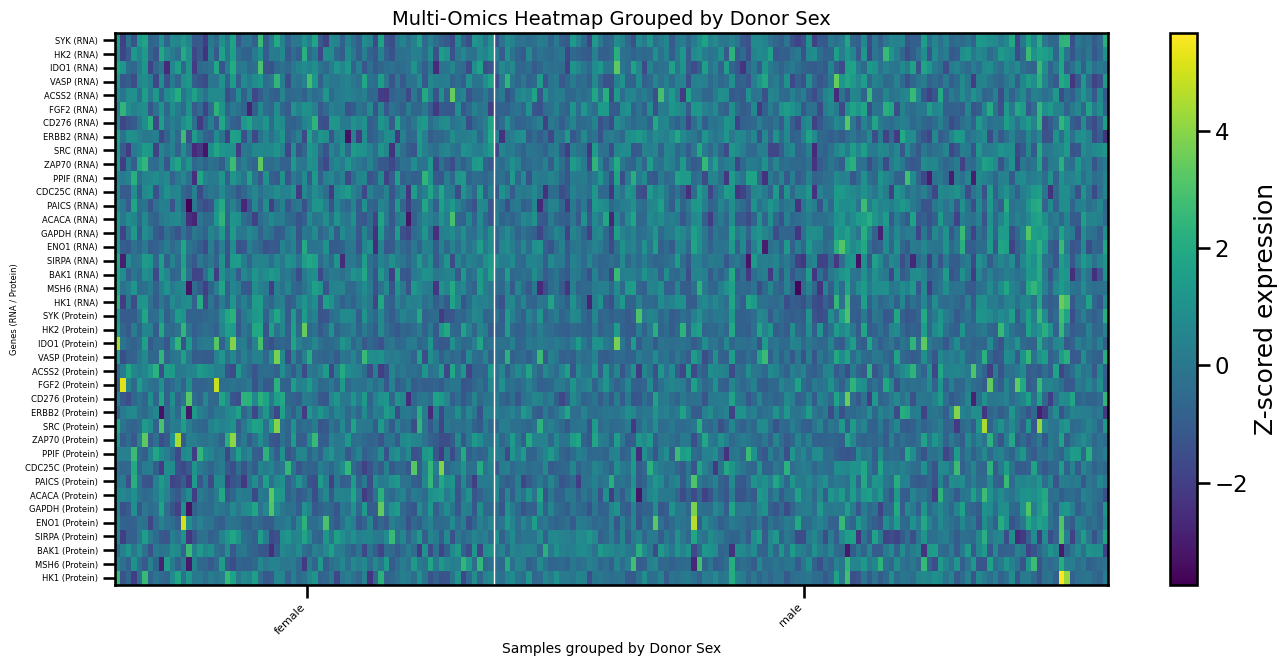

In [66]:
# 4.11 Clustered Heatmap with Clinical Annotations

import matplotlib.pyplot as plt

# 1) Attach gene names to correlation results
corr_with_gene = correlation_results.copy()
corr_with_gene["Gene"] = transcriptomics_corr.index.values  # gene symbols

# 2) Choose top N genes by absolute Spearman correlation
top_n = 20
top_corr = corr_with_gene.sort_values("spearman_r", key=lambda s: s.abs(), ascending=False)
top_genes = top_corr["Gene"].head(top_n).tolist()
print(f"Top {top_n} genes by |Spearman r|:")
print(top_genes)

# 3) Build combined RNA+Protein expression matrix for these genes
rna_mat = transcriptomics_corr.loc[top_genes, :]
prot_mat = proteomics_corr.loc[top_genes, :]

rna_mat_indexed = rna_mat.copy()
rna_mat_indexed.index = [f"{g} (RNA)" for g in top_genes]

prot_mat_indexed = prot_mat.copy()
prot_mat_indexed.index = [f"{g} (Protein)" for g in top_genes]

combined_mat = pd.concat([rna_mat_indexed, prot_mat_indexed], axis=0)

# 4) Z-score rows
def zscore_rows(df):
    mu = df.mean(axis=1)
    sigma = df.std(axis=1).replace(0, np.nan)
    return (df.sub(mu, axis=0)).div(sigma, axis=0)

combined_z = zscore_rows(combined_mat)

# 5) Choose metadata column for grouping
group_candidates = [
    "primary_diagnosis.diagnoses",
    "Donor Sex",
    "ajcc_pathologic_t.diagnoses",
]

if "Sample Source ID" in samples_df.columns:
    join_key = "Sample Source ID"
elif "genestack:accession" in samples_df.columns:
    join_key = "genestack:accession"
else:
    raise RuntimeError("No suitable join key found in samples_df.")

samples_meta = samples_df.set_index(join_key)

group_col = meta_dropdown.value
print("Grouping samples by:", group_col)

if group_col is None:
    raise RuntimeError("None of the candidate metadata columns found for grouping.")

print("Grouping samples by:", group_col)

# 6) Build a simple 1D series of group labels per sample
group_series = samples_meta[group_col].apply(
    lambda x: ", ".join(x) if isinstance(x, list) else x
).fillna("Unknown").astype(str)

# keep only samples present in combined_z (in case of mismatch)
group_series = group_series.reindex(combined_z.columns)

# 7) Determine column order by grouping
# sort samples by group label; samples in same group will be contiguous
group_series_sorted = group_series.sort_values()
ordered_samples = group_series_sorted.index.tolist()

# reorder expression matrix
combined_sorted = combined_z.loc[:, ordered_samples]

# compute boundaries between groups (for vertical lines)
group_sizes = group_series_sorted.value_counts()[group_series_sorted.unique()]
boundaries = group_sizes.cumsum().values[:-1]  # exclude last (end of axis)
group_labels = group_series_sorted.unique()

# 8) Plot heatmap
plt.figure(figsize=(14, 7))
im = plt.imshow(combined_sorted, aspect="auto")
plt.colorbar(im, label="Z-scored expression")

# y-axis: gene (RNA/Protein)
plt.yticks(
    range(len(combined_sorted.index)),
    combined_sorted.index,
    fontsize=6  # smaller font for gene labels
)

plt.xlabel("Samples grouped by " + group_col, fontsize=10)
plt.ylabel("Genes (RNA / Protein)", fontsize=6)
plt.title("Multi-Omics Heatmap Grouped by " + group_col, fontsize=14)

# add vertical lines between groups
for b in boundaries:
    plt.axvline(b - 0.5, color="white", linewidth=1)

# add group labels under x-axis
group_centers = []
start = 0
for size in group_sizes.values:
    center = start + size / 2.0
    group_centers.append(center)
    start += size

def shorten(label):
    if len(label) > 25:
        return label[:25] + "..."
    return label

short_labels = [shorten(g) for g in group_labels]

plt.xticks(
    group_centers,
    short_labels,
    rotation=45,   # diagonal instead of vertical
    ha='right',
    va='top',
    fontsize=8     # significantly smaller font
)

plt.tight_layout()
plt.show()

# Summary & Key Insights

This session demonstrated how **ODM Search Services** enable multi-omics retrieval and integration on top of curated datasets.

By leveraging ODM’s harmonised identifiers, validated metadata, and structured expression groups, we were able to:

- Retrieve samples, metadata, transcriptomics, and proteomics directly through the API  
- Map protein identifiers to gene symbols  
- Align omics layers across shared samples  
- Combine metadata with multi-omics matrices for group-level insights  
- Perform example analyses (correlation, grouped heatmaps)

### 🔑 Key Insight

**Reliable analysis depends on reliable data — ODM provides that reliability.**  
Its harmonisation, indexing, and curation rules ensure that downstream workflows are reproducible and scientifically meaningful.

### 🚀 What’s Next?

In **Session 4**, we apply the same concepts to *single-cell* data, exploring:

- Cell-level metadata  
- Gene expression matrices  
- Marker and cluster discovery  
- High-dimensional queries through Search Services

This completes the training series by showing how ODM supports both bulk and single-cell omics exploration.